In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm
import torch as th
import logging
import networkx as nx
from biokg.link_prediction import LinkPrediction
from biokg.embeddings import *
from biokg.metrics import calc_classification_metrics, make_boxplots

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

treatment_df = pd.read_csv("../data/treatment.edges.csv")
nodes_df = pd.read_csv("../data/nodes.csv")
G = th.load("../data/graph.pt")
data = th.load("../data/data.pt")


/opt/conda/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

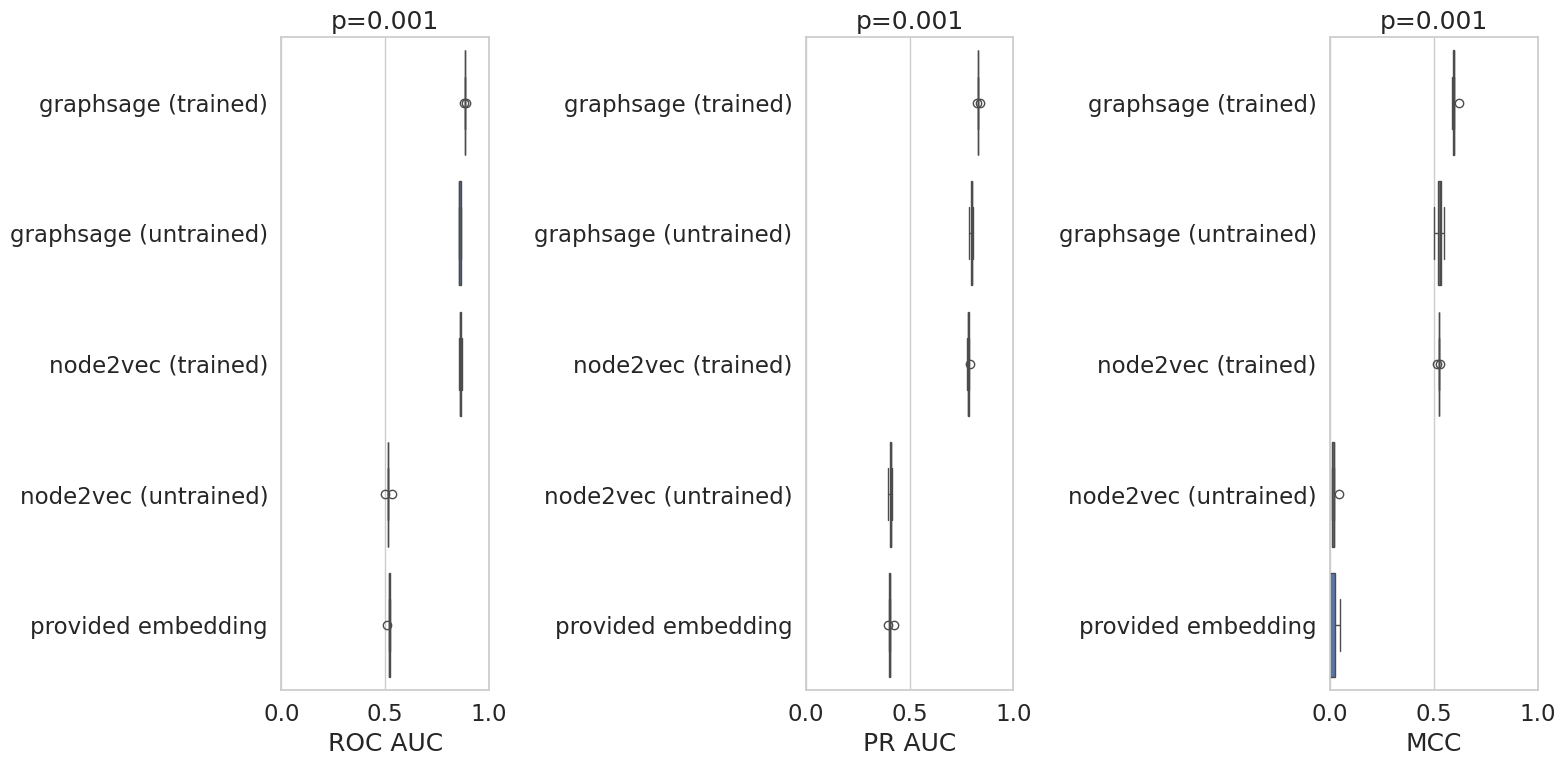

In [7]:
all_predictions = []
pretrained_model = LinkPrediction(embedding_model=PretrainedEmbedding(data=data))
n2v_model = LinkPrediction(embedding_model=Node2VecEmbedding(data=data))
graphsage = LinkPrediction(embedding_model=GraphSAGEEmbedding(data=data))

predictions = graphsage.eval_downstream_model()
predictions['method'] = "graphsage (untrained)"
all_predictions.append(predictions)
graphsage.embedding_model.train()
predictions = graphsage.eval_downstream_model()
predictions['method'] = "graphsage (trained)"
all_predictions.append(predictions)

predictions = n2v_model.eval_downstream_model()
predictions['method'] = "provided embedding"
all_predictions.append(predictions)

predictions = n2v_model.eval_downstream_model()
predictions['method'] = "node2vec (untrained)"
all_predictions.append(predictions)
n2v_model.embedding_model.train()
predictions = n2v_model.eval_downstream_model()
predictions['method'] = "node2vec (trained)"
all_predictions.append(predictions)

all_predictions = pd.concat(all_predictions)
metrics = calc_classification_metrics(all_predictions)
make_boxplots(metrics)

In [8]:
n2v_model.train_downstream_model()
predictions, predictions_z_score_molecule, predictions_z_score_disease = n2v_model.predict_downstream_model()
pred_mask = predictions > 0.95
z_score_disease_mask = predictions_z_score_disease > 1.65 # p-value of 0.05 for right-tailed distribution
z_score_molecule_mask = predictions_z_score_molecule > 1.65
mask_n2v = pred_mask * z_score_disease_mask * z_score_molecule_mask

100%|██████████████████████████████████████████████████████████████████████████████████████████| 16716/16716 [32:11<00:00,  8.65it/s]


In [ ]:
graphsage.train_downstream_model()
predictions, predictions_z_score_molecule, predictions_z_score_disease = graphsage.predict_downstream_model()
pred_mask = predictions > 0.95
z_score_disease_mask = predictions_z_score_disease > 1.65 # p-value of 0.05 for right-tailed distribution
z_score_molecule_mask = predictions_z_score_molecule > 1.65
mask_graphsage = pred_mask * z_score_disease_mask * z_score_molecule_mask

 60%|██████████████████████████████████████████████████████▏                                   | 10062/16716 [17:41<16:11,  6.85it/s]

In [61]:
mask = mask_n2v | mask_graphsage

In [62]:
# Find the predictions that i) are confidently predicted and ii) represent the most enriched hits for the molecule-disease pair.
# In other words, if a disease frequent flier has _all_ of its molecule predictions over the threshold of 0.95, 
# then we only keep the highest scoring molecules with a p-value of 0.05.
# Get enriched and highly predicted molecule-disease pairs
mol_ix, dis_ix = np.argwhere(mask).T

# Format into a dataframe

disease_mask = np.array([i=="Disease" for i in data.node_type])
molecule_mask = np.array([i=="Molecule" for i in data.node_type])

disease_ids = np.array(data.id)[disease_mask]
molecule_ids = np.array(data.id)[molecule_mask]

disease_names = np.array(data.name)[disease_mask]
molecule_names = np.array(data.name)[molecule_mask]

results = []
for _mol_ix, _dis_ix in zip(mol_ix, dis_ix):
    prob = predictions[_mol_ix, _dis_ix]
    z_score_disease = predictions_z_score_disease[_mol_ix, _dis_ix]
    z_score_molecule = predictions_z_score_molecule[_mol_ix, _dis_ix]
    _mol_id = molecule_ids[_mol_ix]
    _dis_id = disease_ids[_dis_ix]
    results.append(dict(mol_id=_mol_id, 
                        dis_id=_dis_id,
                        mol_ix=_mol_ix,
                        dis_ix=_dis_ix,
                        mol_name=molecule_names[_mol_ix],
                        dis_name=disease_names[_dis_ix],
                        pair_id = f"{_mol_id}::{_dis_id}",
                        prob=prob,
                        z_score_disease=z_score_disease,
                        z_score_molecule=z_score_molecule))
results = pd.DataFrame(results).sort_values(by='prob')
# Remove known treatments
results= results[~results.pair_id.isin(treatment_df.pair_id)]
results.to_csv("../data/top_predictions.csv", index=False)
print(len(results), "putative molecule-disease treatments")

4242 putative molecule-disease treatments


In [63]:
results.head(20)

,mol_id,dis_id,mol_ix,dis_ix,mol_name,dis_name,pair_id,prob,z_score_disease,z_score_molecule
3964,CHEMBL.COMPOUND:CHEMBL3990028,MONDO:0001134,3229,1609,BLESELUMAB,essential hypertension,CHEMBL.COMPOUND:CHEMBL3990028::MONDO:0001134,0.489990,-1.110352,-0.761230
1648,CHEMBL.COMPOUND:CHEMBL1345,MONDO:0005306,1520,1783,GUANETHIDINE MONOSULFATE,ankylosing spondylitis,CHEMBL.COMPOUND:CHEMBL1345::MONDO:0005306,0.509766,-0.519043,-0.296631
1802,CHEMBL.COMPOUND:CHEMBL2108675,MONDO:0005247,1638,2007,DUPILUMAB,bacterial urinary tract infection,CHEMBL.COMPOUND:CHEMBL2108675::MONDO:0005247,0.520020,-0.581543,-0.267334
4034,CHEMBL.COMPOUND:CHEMBL3286580,MONDO:0005089,3362,1228,IDALOPIRDINE,sarcoma,CHEMBL.COMPOUND:CHEMBL3286580::MONDO:0005089,0.549805,-0.302490,0.060181
4668,DRUGBANK:DB08619,MONDO:0018874,9520,1112,Testosterone succinate,acute myeloid leukemia,DRUGBANK:DB08619::MONDO:0018874,0.569824,-0.086731,0.007965
2060,CHEMBL.COMPOUND:CHEMBL2109653,MONDO:0005247,1821,2007,BERMEKIMAB,bacterial urinary tract infection,CHEMBL.COMPOUND:CHEMBL2109653::MONDO:0005247,0.580078,-0.168091,0.853516
3079,CHEMBL.COMPOUND:CHEMBL93047,MONDO:0001134,2598,1609,ETHADIONE,essential hypertension,CHEMBL.COMPOUND:CHEMBL93047::MONDO:0001134,0.589844,-0.207520,0.255371
183,CHEMBL.COMPOUND:CHEMBL471737,MONDO:0000675,651,4593,IVABRADINE,pain agnosia,CHEMBL.COMPOUND:CHEMBL471737::MONDO:0000675,0.589844,0.068298,0.201904
4003,CHEMBL.COMPOUND:CHEMBL550781,MONDO:0000675,3331,4593,DEXLOXIGLUMIDE,pain agnosia,CHEMBL.COMPOUND:CHEMBL550781::MONDO:0000675,0.600098,0.147949,0.280029
4868,UMLS:C1277078,MONDO:0001134,10261,1609,"Red blood cells, blood product",essential hypertension,UMLS:C1277078::MONDO:0001134,0.600098,-0.114807,0.873047


Some incredibly dubious predictions, but I have run out of time

In [64]:
results.groupby("dis_name").agg({'mol_name': list, "prob":np.mean}).sort_values('prob', ascending=False).head(10)

/tmp/ipykernel_125424/1990675224.py:1: FutureWarning: The provided callable <function mean at 0x7f1d2434d870> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  results.groupby("dis_name").agg({'mol_name': list, "prob":np.mean}).sort_values('prob', ascending=False).head(10)


,mol_name,prob
dis_name,,
"IgE responsiveness, atopic",[ISOSORBIDE],0.979980
Other fatty acid oxidation disorders,[SELEXIPAG],0.979980
subacute delirium,[CELIPROLOL HYDROCHLORIDE],0.979980
diffuse large B-cell lymphoma,[IPRINDOLE],0.979980
amenorrhea,[LOBUCAVIR],0.979980
streptococcal infection,"[ARIPIPRAZOLE, GADOBENATE DIMEGLUMINE, MEPIVAC...",0.976641
staphylococcus aureus infection,"[ARIPIPRAZOLE, CLENBUTEROL HYDROCHLORIDE, FLAV...",0.975064
seasonal allergic rhinitis,"[1-(tert-butylamino)-3-(4-morpholino-1,2,5-thi...",0.971360
acute gonococcal cervicitis,"[LEVOBUPIVACAINE, DELAFLOXACIN, ISOETHARINE HY...",0.970638
